### 筆記
* keras_segmentation 最新版本：0.3.0
* 官網上_unet有activation='relu'，但實際最新安裝的版本沒有(activation=None) 
* 重要：keras_segmentation的vgg_unet中vgg16的部分有先用imagenet(一個大型視覺資料庫)進行預訓練(as a pretrained model)，起始參數並非重頭開始隨機決定的！

### 還差什麼？
* 一個能夠產出預測結果(n x InputSize^2 x n_class ➡ n x 512 x 512)的函式

## 第一部分：使用keras_segmentation這個套件建立vgg_unet

In [1]:
import tensorflow as tf
from keras_segmentation.models.unet import vgg_unet
import keras
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [3]:
INPUT_SIZE = 64
model_ = vgg_unet(n_classes = 2, input_height = INPUT_SIZE, input_width = INPUT_SIZE)

In [3]:
model_.train(
    train_images = 'DATA\\WW600WL100\\train\\images',
    train_annotations = 'DATA\\WW600WL100\\train\\annotations_tumor as kidney',
    epochs = 10, # default = 5
    steps_per_epoch = 512, # default = 512
    verify_dataset = False, # 當資料量很多時檢驗資料集會花很多時間
    checkpoints_path = 'DATA\\WW600WL100\\model_\\vgg_unet'
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
512/512 [==============================] - 217s 424ms/step - loss: 0.0908 - accuracy: 0.9729
saved  DATA\WW600WL100\model_\vgg_unet.0
Epoch 2/10
512/512 [==============================] - 233s 455ms/step - loss: 0.0184 - accuracy: 0.9938
saved  DATA\WW600WL100\model_\vgg_unet.1
Epoch 3/10
512/512 [==============================] - 239s 467ms/step - loss: 0.0115 - accuracy: 0.9960
saved  DATA\WW600WL100\model_\vgg_unet.2
Epoch 4/10
512/512 [==============================] - 239s 467ms/step - loss: 0.0099 - accuracy: 0.9966
saved  DATA\WW600WL100\model_\vgg_unet.3
Epoch 5/10
512/512 [==============================] - 239s 467ms/step - loss: 0.0078 - accuracy: 0.9972
saved  DATA\WW600WL100\model_\vgg_unet.4
Epoch 6/10
512/512 [==============================] - 240s 469ms/step - loss: 0.0062 - accuracy: 0.9978
saved  DATA\WW600WL100\model_\vgg_unet.5
Epoch 7/10
512/512 [==============

In [4]:
from keras_segmentation.predict import predict
pr = predict(inp="DATA\\WW600WL100\\train\\images\\KiTS_case00000_0257.png", out_fname=None,
            checkpoints_path='DATA\\WW600WL100\\model_\\vgg_unet')

loaded weights  DATA\WW600WL100\model_\vgg_unet.9



In [5]:
img_train_sample = cv2.imread('DATA\\WW600WL100\\train\\images\\KiTS_case00000_0257.png')
seg_train_sample = cv2.imread('DATA\\WW600WL100\\train\\annotations_tumor as kidney\\KiTS_case00000_0257.png',cv2.IMREAD_GRAYSCALE)

img_train_sample = cv2.resize(img_train_sample, (INPUT_SIZE, INPUT_SIZE))
seg_train_sample = cv2.resize(seg_train_sample, (INPUT_SIZE, INPUT_SIZE))

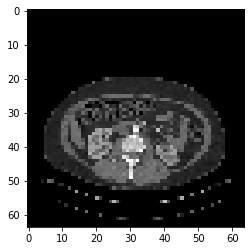

In [6]:
plt.imshow(img_train_sample)

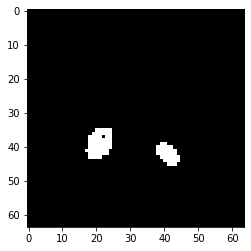

In [7]:
plt.imshow(seg_train_sample, cmap='gray') 

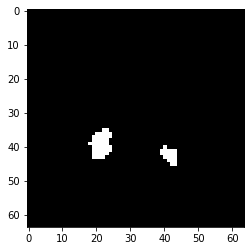

In [8]:
plt.imshow(pr, cmap='gray') 

In [9]:
from keras_segmentation.predict import predict
pr = predict(inp="DATA\\WW600WL100\\test\\images\\KiTS_case00002_0140.png", out_fname=None,
            checkpoints_path='DATA\\WW600WL100\\model_\\vgg_unet')

img_test_sample = cv2.imread('DATA\\WW600WL100\\test\\images\\KiTS_case00002_0140.png')
seg_test_sample = cv2.imread('DATA\\WW600WL100\\test\\annotations_tumor as kidney\\KiTS_case00002_0140.png',cv2.IMREAD_GRAYSCALE)

img_test_sample = cv2.resize(img_test_sample, (INPUT_SIZE, INPUT_SIZE))
seg_test_sample = cv2.resize(seg_test_sample, (INPUT_SIZE, INPUT_SIZE))

loaded weights  DATA\WW600WL100\model_\vgg_unet.9


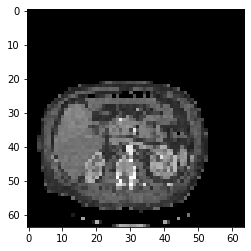

In [13]:
plt.imshow(img_test_sample)

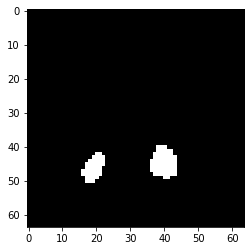

In [14]:
plt.imshow(seg_test_sample, cmap='gray') 

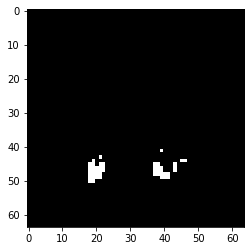

In [15]:
plt.imshow(pr, cmap='gray') 

## 第二部分：「不」使用keras_segmentation這個套件建立vgg_unet

### 讀取函式庫、超參數設定

In [1]:
### 讀取函式庫 ###
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
x_train_path = 'DATA\\WW600WL100\\train\\images'
y_train_path = 'DATA\\WW600WL100\\train\\annotations_tumor as kidney'
checkpoints_path = 'DATA\WW600WL100\\Model'
model_name = 'vgg_unet'
start_from_latest_checkpoints = True

INPUT_SIZE = 64 # input size equal to output size
CLASS_NUM = 2 # background and roi(kidney)

# initialize the number of epochs and batch size
EPOCHS = 10
BATCH_SIZE = 2

IMAGE_ORDERING = 'channels_last' # 不要亂改這個參數

### 在程式中預先準備好資料集(不推薦，當資料集過大時會遇到記憶體不足的問題)

In [3]:
# x_train = []
# y_train = []

In [4]:
# for f in os.listdir(x_train_path):
#     img_array = cv2.imread(os.path.join(x_train_path, f), cv2.IMREAD_GRAYSCALE)
#     img_array = cv2.resize(img_array, (INPUT_SIZE,INPUT_SIZE))
#     x_train.append(img_array)

In [5]:
# for f in os.listdir(y_train_path):
#     img_array = cv2.imread(os.path.join(y_train_path, f), cv2.IMREAD_GRAYSCALE)
#     img_array = cv2.resize(img_array, (INPUT_SIZE,INPUT_SIZE))
#     seg_labels = np.zeros((INPUT_SIZE, INPUT_SIZE, CLASS_NUM)) # channel last
#     for c in range(CLASS_NUM):
#         seg_labels[:, :, c] = (img_array == c).astype(int) 
        
#     ### 因應 keras_segmentation 在輸出層之後額外添加的層 ###
#     seg_labels = np.reshape(seg_labels, (INPUT_SIZE * INPUT_SIZE, CLASS_NUM)) # channel last
#     ###
    
#     y_train.append(seg_labels)

In [6]:
# x_train = np.asarray(x_train)
# y_train = np.asarray(y_train)

In [7]:
# x_train = x_train.reshape(-1, INPUT_SIZE, INPUT_SIZE, 1)  # channel last

In [8]:
# plt.imshow(x_train[256].reshape(INPUT_SIZE, INPUT_SIZE), cmap='gray') 

### 用生成器(generator)生成訓練圖片
使用generator的好處在於，模型在訓練(或驗證)的過程中會依據批量大小生成圖片，不需要在程式中預先準備好資料集(通常資料集都會大到無法一口氣塞入記憶體之中)，減少記憶體的使用空間。另外，使用ImageDataGenerator可以對生成的圖片實施「資料增強(Data Augmentation)」，增加模型的泛化能力。

In [3]:
### 取得資料集中所有的檔案路徑(包含CT影像和其對應標記的路徑) ###
def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            return_value.append((image_full_path,
                                segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}."
                                  .format(image_full_path))

    return return_value

In [4]:
### 將CT影像的陣列轉成適合模型輸入的形式(維度轉換 + 標準化) ###
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first'):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide": # 除以127.5，然後減 1
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean": # 減去ImageNet的平均BGR
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide": # 除以255
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

### 將標記資料的陣列轉成適合模型輸入的形式(維度轉換) ###
def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=False):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: "
                                  "path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, 1)
    else:
        raise DataLoaderError("get_segmentation_array: "
                              "Can't process input type {0}"
                              .format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels


In [5]:
import itertools
import random
from keras.preprocessing.image import ImageDataGenerator

def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width, do_augment=False):

    img_seg_pairs = get_pairs_from_paths(images_path, segs_path) 
        # 取得資料集中所有的檔案路徑(包含CT影像和其對應標記的路徑)
    random.shuffle(img_seg_pairs) # 打散檔案路徑
    zipped = itertools.cycle(img_seg_pairs) 
        # 將檔案路徑用循環迭代器(iterator)封裝；範例：cycle('ABCD') --> A B C D A B C D ...

    while True:
        X = []
        Y = []
        for _ in range(batch_size): # batch_size多大，就取得多少份資料
            im, seg = next(zipped) # 取得CT影像和其對應標記的路徑

            im = cv2.imread(im, 1) # 1 = cv2.IMREAD_COLOR (讀取彩色圖片)
            seg = cv2.imread(seg, 1)
            
            if do_augment:
                ### Example of transforming images and masks together. ###
                # we create two instances with the same arguments
                data_gen_args = dict(featurewise_center=False, # 範例程式碼為True，但這裡我只是要把一張圖片變成是增強後的型態
                         featurewise_std_normalization=False, # 範例程式碼為True，但這裡我只是要把一張圖片變成是增強後的型態
                         rotation_range=30, # 範例程式碼為90
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
                image_datagen = ImageDataGenerator(**data_gen_args)
                mask_datagen = ImageDataGenerator(**data_gen_args)
                # Provide the same seed and keyword arguments to the fit and flow methods
                seed = random.randint(0,10000)
                im_itr = image_datagen.flow(im.reshape(1, 512, 512, 3), batch_size=1, seed=seed)  
                seg_itr = mask_datagen.flow(seg.reshape(1, 512, 512, 3), batch_size=1, seed=seed)  
                im = next(im_itr).reshape(512, 512, 3)
                seg = next(seg_itr).reshape(512, 512, 3)
            
            # 將CT影像和其對應的標記轉換成模型輸入的形式
            X.append(get_image_array(im, input_width,
                                     input_height, imgNorm="sub_mean", ordering=IMAGE_ORDERING)) 
                # imgNorm預設為sub_mean"，但這裡我改用圖片最常實施的正規化方法(同除以255)
            Y.append(get_segmentation_array(
                seg, n_classes, output_width, output_height))

        yield np.array(X), np.array(Y)

Using TensorFlow backend.


In [40]:
# generator_example = image_segmentation_generator(images_path = x_train_path, segs_path = y_train_path, 
#                                                  batch_size = 2, n_classes = CLASS_NUM, 
#                                                  input_height = INPUT_SIZE, input_width = INPUT_SIZE,
#                                                  output_height = INPUT_SIZE, output_width = INPUT_SIZE, do_augment=False)
# item = next(generator_example)

In [7]:
# item[0].shape # X的維度為 (n, INPUT_SIZE, INPUT_SIZE, 3)

(2, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


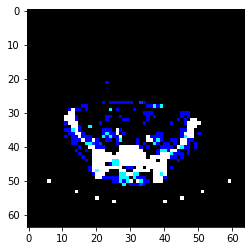

In [8]:
# plt.imshow(item[0][0])

In [10]:
# item[1].shape # Y的維度為 (n, INPUT_SIZE x INPUT_SIZE, class number)

(2, 4096, 2)

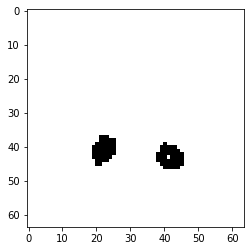

In [43]:
# plt.imshow(item[1][0][:,0].reshape(INPUT_SIZE,INPUT_SIZE), cmap = 'gray')

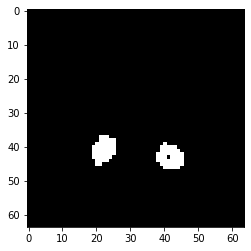

In [44]:
# plt.imshow(item[1][0][:,1].reshape(INPUT_SIZE,INPUT_SIZE), cmap = 'gray')

In [6]:
# 建立訓練資料的生成器
train_gen = image_segmentation_generator(images_path = x_train_path, segs_path = y_train_path, batch_size = BATCH_SIZE, 
                                         n_classes = CLASS_NUM, input_height = INPUT_SIZE, input_width = INPUT_SIZE, 
                                         output_height = INPUT_SIZE, output_width = INPUT_SIZE, do_augment=False)

### 設定回調函式(callbacks)
keras_segmentation自定義的回調函式好像缺了什麼，直接用在這份程式碼中並不會正常運作，因此我先註解掉，改用keras.callbacks.ModelCheckpoint定期儲存模型參數。

In [18]:
# from keras.callbacks import Callback
# class CheckpointsCallback(Callback):
#     def __init__(self, checkpoints_path):
#         self.checkpoints_path = checkpoints_path

#     def on_epoch_end(self, epoch, logs=None):
#         if self.checkpoints_path is not None:
#             self.model.save_weights(self.checkpoints_path + "." + str(epoch))
#             print("saved ", self.checkpoints_path + "." + str(epoch))

In [7]:
from keras.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint(os.path.join(checkpoints_path, model_name + '_{epoch}.h5'), 
                             save_weights_only=True, 
                             period=5)] # period=5：每5個Epoch才會儲存一次參數

### 建立模型

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
import keras

In [9]:
input_height = input_width = INPUT_SIZE
n_classes = CLASS_NUM

#### Eecoder - VGG16

In [10]:
assert input_height % 32 == 0
assert input_width % 32 == 0

if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

if IMAGE_ORDERING == 'channels_first':
    img_input = Input(shape=(3, input_height, input_width))
elif IMAGE_ORDERING == 'channels_last':
    img_input = Input(shape=(input_height, input_width, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same',
           name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same',
           name='block1_conv2', data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                 data_format=IMAGE_ORDERING)(x)
f1 = x
# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           name='block2_conv1', data_format=IMAGE_ORDERING)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same',
           name='block2_conv2', data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                 data_format=IMAGE_ORDERING)(x)
f2 = x

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same',
           name='block3_conv1', data_format=IMAGE_ORDERING)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same',
           name='block3_conv2', data_format=IMAGE_ORDERING)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same',
           name='block3_conv3', data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                 data_format=IMAGE_ORDERING)(x)
f3 = x

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block4_conv1', data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block4_conv2', data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block4_conv3', data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                 data_format=IMAGE_ORDERING)(x)
f4 = x

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block5_conv1', data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block5_conv2', data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same',
           name='block5_conv3', data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                 data_format=IMAGE_ORDERING)(x)
f5 = x

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### 對Eecoder載入用imagenet預訓練的參數

In [11]:
import keras
pretrained='imagenet'

if IMAGE_ORDERING == 'channels_first':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
elif IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

if pretrained == 'imagenet':
    VGG_Weights_path = keras.utils.get_file(
        pretrained_url.split("/")[-1], pretrained_url)
    Model(img_input, x).load_weights(VGG_Weights_path)

#### Decoder (這裡我有為了讓輸出大小和輸入大小保持一致新增一個含有上取樣層的block)

In [12]:
o = f4

o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(512, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f3], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(256, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f2], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(128, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (concatenate([o, f1], axis=MERGE_AXIS))
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)

# 增加一個block讓圖片的輸出大小等於輸出大小
o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
o = (Conv2D(64, (3, 3), padding='valid', data_format=IMAGE_ORDERING))(o)
o = (BatchNormalization())(o)
# 額外新增的程式碼到這一行為止

o = Conv2D(n_classes, (3, 3), padding='same', data_format=IMAGE_ORDERING)(o) # 輸出層

### keras_segmentation 在輸出層之後額外添加的層 ###
if IMAGE_ORDERING == 'channels_first':
    o = (Reshape((n_classes, INPUT_SIZE * INPUT_SIZE)))(o)
    o = (Permute((2, 1)))(o)
elif IMAGE_ORDERING == 'channels_last':
    o = (Reshape((INPUT_SIZE * INPUT_SIZE, n_classes)))(o)
o = (Activation('softmax'))(o)
###

In [13]:
model = Model(img_input, o)

#### 查看模型架構

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

### 編譯模型

In [15]:
from tensorflow.keras.optimizers import Adam, Adadelta
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adadelta(lr = 1.0), 
              # 雖然keras_segmentation是用 'adadelta' 做為優化器(優化器參數用預設的，學習率為1.0)，
              # 但我直接輸入'adadelta'，之後查看學習率卻是0.001，所以最好設定Adadelta(lr = 1.0)而非直接輸入'adadelta'
              #optimizer = 'adadelta',
              metrics = ['accuracy'])

In [16]:
import keras.backend as K
print(K.eval(model.optimizer.lr)) # 確保是1.0

1.0


In [41]:
# import keras.backend as K
# print(K.eval(model.optimizer.lr)) # 錯誤的版本 --> 學習將會變得緩慢

0.001


### 訓練模型

In [17]:
if start_from_latest_checkpoints:
    try:
        model.load_weights(
            os.path.join(
                checkpoints_path, 
                model_name + '_' + str(max([int(i.split('_')[-1][:-3]) for i in os.listdir(checkpoints_path)])) + '.h5'
            )
        )
    except:
        print('Model weights not found!')

if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)
    print('-----建立新資料夾：' + checkpoints_path + '-----') 


model.fit_generator(
    train_gen,
    steps_per_epoch = 512, 
    #steps_per_epoch = len(x_train) // BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1,
    callbacks=callbacks
)

# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Model weights not found!
-----建立新資料夾：DATA\WW600WL100\Model-----
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
512/512 [==============================] - 139s 271ms/step - loss: 0.0901 - acc: 0.9734
Epoch 2/10
512/512 [==============================] - 130s 255ms/step - loss: 0.0203 - acc: 0.9932
Epoch 3/10
512/512 [==============================] - 133s 260ms/step - loss: 0.0119 - acc: 0.9959
Epoch 4/10
512/512 [==============================] - 134s 262ms/step - loss: 0.0084 - acc: 0.9970
Epoch 5/10
512/512 [==============================] - 134s 262ms/step - loss: 0.0069 - acc: 0.9975
Epoch 6/10
512/512 [==============================] - 134s 263ms/step - loss: 0.0057 - acc: 0.9979
Epoch 7/10
512/512 [==============================] - 131s 255ms/step - loss: 0.0046 - acc: 0.9983
Epoch 8/10
512/512 [==============================] - 131s 255ms/step - loss: 0.0044 - acc: 0.9984
Epoch 9/10
512/512 [==============================

### 測試模型預測結果(from訓練集)

In [18]:
img_train_sample = cv2.imread('DATA\\WW600WL100\\train\\images\\KiTS_case00000_0257.png')
seg_train_sample = cv2.imread('DATA\\WW600WL100\\train\\annotations_tumor as kidney\\KiTS_case00000_0257.png',cv2.IMREAD_GRAYSCALE)

In [19]:
img_train_sample.shape

(512, 512, 3)

In [20]:
img_train_sample = cv2.resize(img_train_sample, (INPUT_SIZE, INPUT_SIZE))
seg_train_sample = cv2.resize(seg_train_sample, (INPUT_SIZE, INPUT_SIZE))

# 記得先將要預測的圖片進行正規化(之前忘記做這一步害死我了)

## 之前用什麼方法正規化現在就要用什麼方法正規化 (sub_mean of ImageNet)

In [21]:
pr_in = img_train_sample.copy()
pr_in = pr_in.astype(np.float32)
pr_in[:, :, 0] -= 103.939 # B
pr_in[:, :, 1] -= 116.779 # G
pr_in[:, :, 2] -= 123.68 # R
pr_in = pr_in[:, :, ::-1] 
    # ::-1 順序相反操作 例：[123] --> [321] 
    # 目的：對第三個維度進行置換，使BGR變成RGB

In [22]:
pr = model.predict(np.array([pr_in]))[0]

In [23]:
pr = pr.reshape(INPUT_SIZE, INPUT_SIZE, n_classes)

In [24]:
pr[0][0][0]

0.9999951

In [25]:
pr[0][0][1]

4.9363916e-06

In [26]:
pr[0][0][0] + pr[0][0][1]

1.0

In [27]:
pr.shape

(64, 64, 2)

In [28]:
pr = pr.argmax(axis = 2)

In [29]:
pr.shape

(64, 64)

In [30]:
set(pr.flatten())

{0, 1}

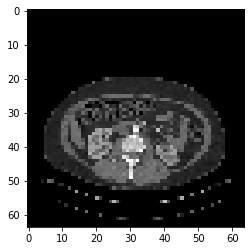

In [31]:
plt.imshow(img_train_sample)

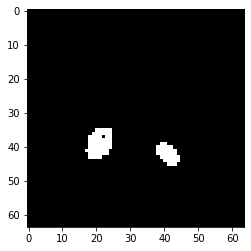

In [32]:
plt.imshow(seg_train_sample, cmap='gray') 

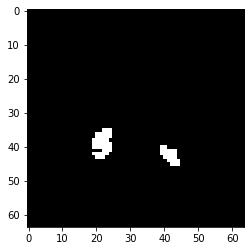

In [33]:
plt.imshow(pr, cmap='gray') 

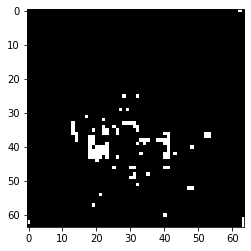

In [34]:
# plt.imshow(pr, cmap='gray') # 之前用到錯誤的學習率(0.001)跑出來的結果，模型尚未抓到訓練資料的特徵

### 測試模型預測結果(from測試集)

In [34]:
img_test_sample = cv2.imread('DATA\\WW600WL100\\test\\images\\KiTS_case00002_0140.png')
seg_test_sample = cv2.imread('DATA\\WW600WL100\\test\\annotations_tumor as kidney\\KiTS_case00002_0140.png',cv2.IMREAD_GRAYSCALE)

In [35]:
img_test_sample = cv2.resize(img_test_sample, (INPUT_SIZE, INPUT_SIZE))
seg_test_sample = cv2.resize(seg_test_sample, (INPUT_SIZE, INPUT_SIZE))

In [36]:
pr_in = img_test_sample.copy()
pr_in = pr_in.astype(np.float32)
pr_in[:, :, 0] -= 103.939 # B
pr_in[:, :, 1] -= 116.779 # G
pr_in[:, :, 2] -= 123.68 # R
pr_in = pr_in[:, :, ::-1] 

pr = model.predict(np.array([pr_in]))[0]
pr = pr.reshape(INPUT_SIZE, INPUT_SIZE, n_classes)
pr = pr.argmax(axis = 2)

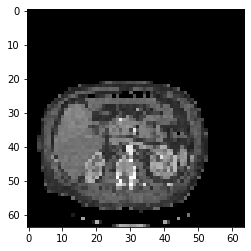

In [37]:
plt.imshow(img_test_sample, cmap='gray') 

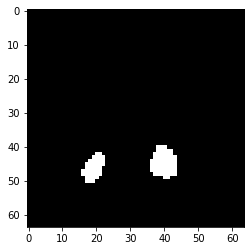

In [38]:
plt.imshow(seg_test_sample, cmap='gray') 

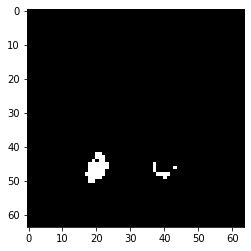

In [39]:
plt.imshow(pr.reshape(INPUT_SIZE, INPUT_SIZE), cmap='gray') 